# TODO:
Bodky -  izolant
Ciarky horizontalne/vertikalne - kov

Klasifikator zavisli na smeru
Siet nech vrati obrazok a nie hodnotu a podla nej hodnotit, a postupne nech pozera malu oblast ako 5x5 - 9x9 a vrati 

Spocitat orientaci gradientu obrazku
pricom mame 3 typy textur
Veritalkne ciary, horizontalne ciary a bodky

Vypocitat gradient orientaci pixelu a zistit aky uyhol ma textura
spravit obrazok ulhov ktory bude zostrojeny nad obrazkom a podla priemeru, ci vacsina uhlov bude rovnakych v smeru vertikalne alebo otoceny o 90 horiontalne a ked budu chaoticke tak bodky

Pokial je to bodtkove tak bude gradient vo vsekych smeroch.

Spravit graf a podla krivky zistit ako klasifikovat. 

Vypocitat vsetky mozne metody a statisticky to urcit ktore je najlepsie

odhad derivacii odstranit sum pomocou filtru gausianom alebo nieco takym inym... 


Osekavat obrazky len do stvorca a pozerat po ovela mensich castiach (okraje cipu netreba len vyrez)

# LOAD IMAGES

In [1]:
import helper_func as hf
import cv2
import numpy as np
import pandas as pd
import os
from pprint import pprint 
from matplotlib import pyplot as plt

overview = os.path.join('.', 'data', 'overview')
focus = os.path.join('.', 'data', 'focus')
cnn = os.path.join('.', 'data', 'CNN_data')
cnn_cut = os.path.join('.', 'data', 'cnn_data_cut')

images = hf.load_data(overview, grayscale=False)
# images = hf.load_data(focus, grayscale=False)
# images = hf.load_data(cnn, grayscale=False)
img = images[0]['img']

Loaded (8) images from .\data\overview


In [ ]:
## CREATE DATASET
# for image in images:
#     print("{} W:{} H:{}".format(image['name'], image['w'], image['h']))
#     h = math.floor(image['h']/255)
#     w = math.floor(image['w']/255)
#     for x in range(0, h):
#         for y in range(0, w):
#             crop_img = image['img'][x*255:(x*255)+255, y*255:(y*255)+255]
#             path = os.path.join(cnn_cut, f"{re.sub('.png', '', image['name'])}_{x}x{y}.png")
#             cv2.imwrite(path, crop_img)

# END LOAD


# Local Binary Patern
https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.local_binary_pattern

## Scikit hog implementation

### skimage.feature.hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys', visualize=False, transform_sqrt=False, feature_vector=True, multichannel=None, *, channel_axis=None)

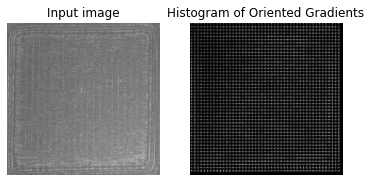

In [2]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

fd, hog_image = hog(images[0]['img'], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## Mahotas LBP

https://mahotas.readthedocs.io/en/latest/lbp.html

# Gabor filter

In [3]:
from __future__ import print_function

import numpy as np
import cv2
from multiprocessing.pool import ThreadPool


def build_filters():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

def process_threaded(img, filters, threadn = 8):
    accum = np.zeros_like(img)
    def f(kern):
        return cv2.filter2D(img, cv2.CV_8UC3, kern)
    pool = ThreadPool(processes=threadn)
    for fimg in pool.imap_unordered(f, filters):
        np.maximum(accum, fimg, accum)
    return accum

filters = build_filters()

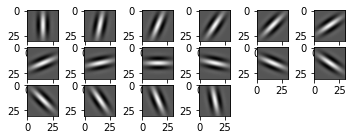

In [4]:
import pylab as pl

filters_img = np.asarray(filters)
for i in range(0, len(filters_img)):
    pl.subplot(6,6,i + 1)
    pl.imshow(filters_img[i],cmap="gray")
pl.show()

In [8]:
hor_filters = [filters_img[7], filters_img[8], filters_img[9]]
for img in images:
    img_gabor = [
        {"img": img["img"], "label": "img"},
        {"img": process(img["img"], filters), "label": "every gabor"},
        {"img": process(img["img"], hor_filters), "label": "only horizontal gabor"}
    ]
    hf.showCW(img_gabor, type="cw_m", dict='img')
    # break

# COMPUTE AVERAGE BRIGHTNESS FOR DATA

In [11]:
import math
from PIL import Image, ImageStat

# Convert image to greyscale, return average pixel brightness.
def brightness_1( im_file ):
   im = Image.open(im_file).convert('L')
   stat = ImageStat.Stat(im)
   return stat.mean[0]

# Convert image to greyscale, return RMS pixel brightness.
def brightness_2( im_file ):
   im = Image.open(im_file).convert('L')
   stat = ImageStat.Stat(im)
   return stat.rms[0]

# Average pixels -> perceived brightness.
def brightness_3( im_file ):
   im = Image.open(im_file)
   stat = ImageStat.Stat(im)
   r,g,b = stat.mean
   return math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))

# RMS of pixels -> perceived brightness.
def brightness_4( im_file ):
   im = Image.open(im_file)
   stat = ImageStat.Stat(im)
   r,g,b = stat.rms
   return math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))

# Calculate PB of pixels, then return average.
def brightness_5( im_file ):
   im = Image.open(im_file)
   stat = ImageStat.Stat(im)
   gs = (math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2)) 
         for r,g,b in im.getdata())
   return sum(gs)/stat.count[0]

In [12]:
import numpy as np
import cv2
from collections import namedtuple

#brange brightness range
#bval brightness value
BLevel = namedtuple("BLevel", ['brange', 'bval'])

#all possible levels
_blevels = [
    BLevel(brange=range(0, 24), bval=0),
    BLevel(brange=range(23, 47), bval=1),
    BLevel(brange=range(46, 70), bval=2),
    BLevel(brange=range(69, 93), bval=3),
    BLevel(brange=range(92, 116), bval=4),
    BLevel(brange=range(115, 140), bval=5),
    BLevel(brange=range(139, 163), bval=6),
    BLevel(brange=range(162, 186), bval=7),
    BLevel(brange=range(185, 209), bval=8),
    BLevel(brange=range(208, 232), bval=9),
    BLevel(brange=range(231, 256), bval=10),
]


def detect_level(h_val):
    h_val = int(h_val)
    for blevel in _blevels:
        if h_val in blevel.brange:
            return blevel.bval
    raise ValueError("Brightness Level Out of Range")


def get_img_avg_brightness(image_path):
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    _, _, v = cv2.split(hsv)

    return int(np.average(v.flatten()))

In [13]:
## OpenCV
# Intesity of individual pixel are img[x,y] greyscale every channel have the same value
# doc -> https://docs.opencv.org/3.4/d5/d98/tutorial_mat_operations.html

def opencv_intensity(image_path):
    img = cv2.imread(image_path)
    height,width,channels = img.shape
    intensity = 0
    for x in range(height):
        for y in range(width):
            intensity += img[x, y][0]
    return intensity/(height*width)

In [15]:
images_cut = os.listdir(cnn_cut)
brightness = {
    'True': {
        'name': [],
        'APB': [],
        'RMS': [],
        'AP_PB': [],
        'RMS_PB': [],
        'PB_AVG': [],
        'intesity': [],
        'brightnessLVL': []
    },
    'False': {
        'name': [],
        'APB': [],
        'RMS': [],
        'AP_PB': [],
        'RMS_PB': [],
        'PB_AVG': [],
        'intesity': [],
        'brightnessLVL': []
    }
}

for image in images_cut:
    print('\rImage to process {}'.format(image), end='')
    image_path = os.path.join(cnn_cut, image)
    brightness[image.split('_')[1]]['name'].append(image)
    brightness[image.split('_')[1]]['APB'].append(round(brightness_1(image_path), 4))
    brightness[image.split('_')[1]]['RMS'].append(round(brightness_2(image_path), 4))
    brightness[image.split('_')[1]]['AP_PB'].append(round(brightness_3(image_path), 4))
    brightness[image.split('_')[1]]['RMS_PB'].append(round(brightness_4(image_path), 4))
    brightness[image.split('_')[1]]['PB_AVG'].append(round(brightness_5(image_path), 4))
    brightness[image.split('_')[1]]['intesity'].append(opencv_intensity(image_path))
    brightness[image.split('_')[1]]['brightnessLVL'].append(detect_level(get_img_avg_brightness(image_path)))

Image to process 13_True_2x2.png

## SVC 

In [9]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

images = hf.load_data(cnn_cut, grayscale=True)
x_train = np.array(list(map(lambda x: x['img'].reshape(255*255), images)))
y_train = np.array(list(map(lambda x: 1 if "True" in x['name'] else 0, images)))

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,test_size=0.2,train_size=0.8)

print(f"X shape: {x_train.shape[1]} after reshaping from (255,255)")
print(f"Train len: {x_train.shape[0]}")
print(f"Test len: {x_test.shape[0]}")

Loaded (97) images from .\data\cnn_data_cut
X shape: 65025 after reshaping from (255,255)
Train len: 77
Test len: 20


In [59]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(x_train, y_train)

y_pred = sgd_clf.predict(x_test)
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

Percentage correct:  75.0


In [43]:
from sklearn.svm import SVC

svc_clf = SVC(kernel='linear')
svc_clf.fit(x_train, y_train)

y_pred = svc_clf.predict(x_test)
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

Percentage correct:  75.0
